# Table of Contents <a id='back'></a>

* [1. Iniciação, carregamento, otimização e exploração de dados](#inicio)
* [2. Enriquecendo dados](#enriquecendo)
* [3.Análise de Dados](#analise)
    * [3.1. Verificando os dados](#verificando)
        * [3.1.1. Quantos eventos ficam nos diários?](#eventos)
        * [3.1.2. Qual é o número médio de eventos por usuário?](#medio)
        * [3.1.3. Qual é o período de tempo que os dados cobrem?](#periodo)
        * [3.1.4. Do momento em que os dados começam a ser completos](#momento)
    * [3.2 Funil de eventos](#funil)
        * [3.2.1. Tipos de eventos e frequência](#tipo)
        * [3.2.2. Do número de usuários que executaram cada uma dessas ações](#numero)
        * [3.2.3. Da ordem das ações](#ordem)
        * [3.2.4.  Funil de eventos e análise de conversão](#conversao)  
    * [3.3. Dos resultados do experimento](#experimento)
        * [3.3.1. Quantos usuários há em cada grupo?](#grupo)
        * [3.3.2. Dos grupos de controle no teste A/A](#controle)
        * [3.3.3.  Dos eventos no grupos A/A](#diferenca)
        * [3.3.4.  Comparando grupo B com grupos A/A](#comparando)
        
* [4. Conclusão](#conclusao)

# Comportamento do usuário para o aplicativo

A empresa ALIMENTOS possui um aplicativo onde vende seus produtos alimentícios. Para o presente estudo, iremos analisar o comportamento do usuário para o aplicativo da empresa.

Para essa análise, iremos estudar o funil de eventos, descobrindo como os usuários chegam à etapa de compra, bem como quantos usuários realmente chegam a essa etapa e também quantos ficam presos nas fases anteriores.

Ainda, veremos os resultados do teste A/A/B para auxiliar os designers a tomarem uma decisão quanto ao novo design do aplicativo.

# 1. Iniciação, carregamento, otimização e exploração de dados <a id='inicio'></a>

Carregaremos as bibliotecas e carregaremos os dados. Verificaremos se há valores ausentes ou/e duplicados. Também iremos checar se o tipo de dados no dataframe estão corretos, assim como se há alguma correção na grafia.

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import datetime as dt
import scipy.stats as stats
from plotly import graph_objects as go
import math as mth

In [112]:
path = 'C://Users//tha_s//Downloads//'
df = pd.read_csv(path + 'logs_exp_us.csv', sep='\t').drop_duplicates()

Iniciaremos a verificação desses dados combinando os conjuntos de dados new_users, events e tests e assim, com uma tabela com todos as informações passaremos a verificação dos dados.

In [113]:
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [114]:
df.columns = ['event_name', 'device_id', 'event_time', 'exp_id']
df.head()

,event_name,device_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [115]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   device_id   243713 non-null  int64 
 2   event_time  243713 non-null  int64 
 3   exp_id      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 24.7 MB


In [116]:
df['event_time_2'] = pd.to_datetime(df['event_time'], unit='s')

In [117]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_name    243713 non-null  object        
 1   device_id     243713 non-null  int64         
 2   event_time    243713 non-null  int64         
 3   exp_id        243713 non-null  int64         
 4   event_time_2  243713 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 26.6 MB


In [118]:
if df.isnull().values.any():
    print("Existem valores ausentes no dataframe.")
else:
    print("Não há valores ausentes no dataframe.")

Não há valores ausentes no dataframe.


In [119]:
if df.duplicated().any():
    print("Existem dados duplicados no dataframe.")
else:
    print("Não há dados duplicados no dataframe.")

Não há dados duplicados no dataframe.


Inicialmente, corrigimos a grafia dos nomes das colunas para que ficassem mais fáceis de ler. Também, verificando que a coluna event_time possuía informação em um único número, criamos uma nova coluna chamada 'event_time_2' no DataFrame df e a preenchemos com os valores da coluna 'event_time' convertidos para o formato de data e hora, especificando que os valores estariam em segundos.

Por fim, não encontramos valores ausentes e tão pouco valores duplicados, já que, quando carregamos o conjunto de dados, removemos quaisquer linhas duplicadas.

[Voltar ao Indice](#back)

# 2. Enriquecendo dados <a id='enriquecendo'></a>

Antes de começarmos a análise, decidimos enriquecer os dados, adicionando uma coluna separada para datas. Utilizaremos a coluna criada anteriormente, event_time_2.

In [120]:
df.head()

,event_name,device_id,event_time,exp_id,event_time_2
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [121]:
df['date'] = df['event_time_2'].dt.date

In [122]:
df['date'] = pd.to_datetime(df['date'])

In [123]:
df.head()

,event_name,device_id,event_time,exp_id,event_time_2,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


[Voltar ao Indice](#back)

# 3. Análise de Dados<a id='analise'></a>

Com os dados carregados e tratados passaremos agora à análise dos dados.

[Voltar ao Indice](#back)

## 3.1. Verificando os dados <a id='verificando'></a>

Antes de passarmos ao estudo do funil de eventos, iremos verificar os dados para encontrar a quantidade de eventos e usuários nos diários, o número médio de eventos por usuário, bem como o período de tempo coberto por esse estudo.

[Voltar ao Indice](#back)

### 3.1.1. Quantos eventos e usuários ficam nos diários? <a id='eventos'></a>

In [124]:
evento_total = df['event_name'].shape[0]
print('Quantidade total de eventos registrados na tabela de logs de eventos:', evento_total)

Quantidade total de eventos registrados na tabela de logs de eventos: 243713


In [125]:
usuarios_total = df['device_id'].nunique()
print('Quantidade total de usuários:', usuarios_total)

Quantidade total de usuários: 7551


Portanto, temos 243713 eventos e 7551 usuários registrados nos diários. 

[Voltar ao Indice](#back)

### 3.1.2. Qual é o número médio de eventos por usuário? <a id='medio'></a>

In [126]:
eventos_per_user = df.groupby('device_id')['event_name'].count().reset_index()
eventos_per_user.columns = ['user_id','num_event']
eventos_per_user

,user_id,num_event
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
...,...,...
7546,9217594193087726423,9
7547,9219463515465815368,17
7548,9220879493065341500,7
7549,9221926045299980007,7


In [127]:
evento_media = eventos_per_user['num_event'].mean()
print(round(evento_media))

32


Agrupando a coluna device_id e event_name, pudemos imprimir uma tabela com o número de eventos por usuário. Assim, utilizando essa nova tabela, conseguimos verificar que a média de eventos por usuário seria 32 eventos.

[Voltar ao Indice](#back)

### 3.1.3. Qual é o período de tempo que os dados cobrem? <a id='periodo'></a>

Iremos verificar o período de tempo que os dados cobrem e, para isso, utilizaremos os métodos min e max. Para uma melhor visualização, iremos criar um histograma por data e hora. 

In [128]:
inicio = df['date'].min()
fim = df['date'].max()
print("Inicio:",inicio)
print("Fim:", fim)

Inicio: 2019-07-25 00:00:00
Fim: 2019-08-07 00:00:00


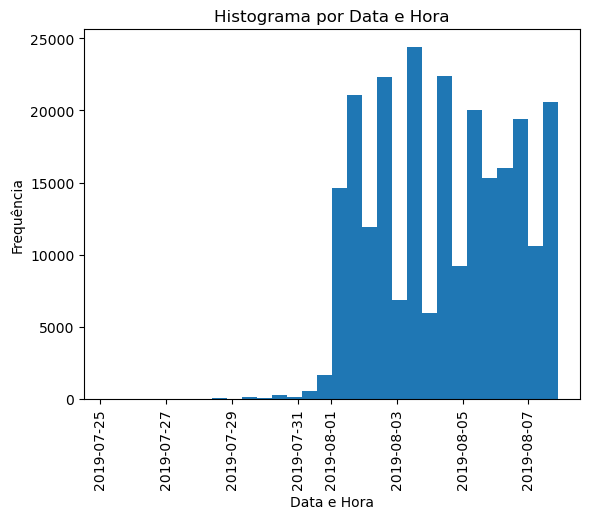

In [129]:
plt.hist(df['event_time_2'], bins=30)
plt.xlabel('Data e Hora')
plt.ylabel('Frequência')
plt.title('Histograma por Data e Hora')
plt.xticks(rotation=90) 
plt.show()

Inicialmente, verificamos que o período que temos nos dados corresponde de 25-07-2019 a 07-08-2019.

Quando da criação do gráfico, vimos que há dias com um volume alto de eventos, enquanto outros dias tiveram poucos eventos e quase não aparecem no gráfico. Podemos determinar que houve períodos com dados incompletos ou inconsistentes, não podendo afirmar que possuímos os dados igualmente completos para todo o período.

[Voltar ao Indice](#back)

### 3.1.4. Do momento em que os dados começam a ser completos  <a id='momento'></a>

Com a constatação anterior e observando o gráfico, entendemos que os dados começaram a ficar completos no período de 01-08-2019 a 07-08-2019. Assim sendo, iremos identificar as referidas datas como início e fim, respectivamente, e iremos filtrar o dataframe.

In [130]:
start_date = pd.to_datetime('2019-08-01')
end_date = pd.to_datetime('2019-08-07')

In [131]:
filtered_df = df[(df['event_time_2'] >= start_date) & (df['event_time_2'] <= end_date)]
filtered_df

,event_name,device_id,event_time,exp_id,event_time_2,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
212977,MainScreenAppear,4259568314706942583,1565135945,248,2019-08-06 23:59:05,2019-08-06
212978,OffersScreenAppear,4259568314706942583,1565135950,248,2019-08-06 23:59:10,2019-08-06
212979,MainScreenAppear,8508320995962440734,1565135955,248,2019-08-06 23:59:15,2019-08-06
212980,MainScreenAppear,4293428370257583636,1565135961,248,2019-08-06 23:59:21,2019-08-06


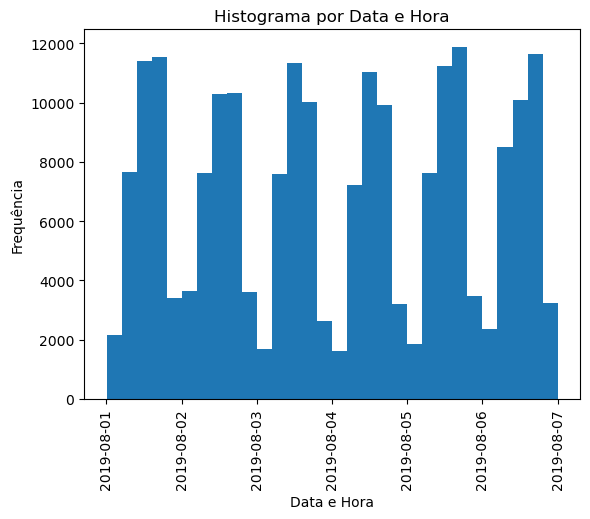

In [132]:
plt.hist(filtered_df['event_time_2'], bins=30)
plt.xlabel('Data e Hora')
plt.ylabel('Frequência')
plt.title('Histograma por Data e Hora')
plt.xticks(rotation=90) 
plt.show()

In [133]:
evento_total_filtered = filtered_df['event_name'].shape[0]
print('Quantidade total de eventos registrados na tabela de logs de eventos:',evento_total_filtered)

Quantidade total de eventos registrados na tabela de logs de eventos: 209791


In [134]:
usuarios_total_filtered = filtered_df['device_id'].nunique()
print('Quantidade total de usuário:', usuarios_total_filtered)

Quantidade total de usuário: 7335


In [135]:
perda_eventos = ((evento_total - evento_total_filtered) / evento_total) * 100
print('Porcentagem de eventos perdidos:', perda_eventos)

Porcentagem de eventos perdidos: 13.918830755848067


In [136]:
perda_usuarios = ((usuarios_total - usuarios_total_filtered) / usuarios_total) * 100
print('Porcentagem de usuário perdidos:', perda_usuarios)

Porcentagem de usuário perdidos: 2.860548271752086


In [137]:
groups = filtered_df.groupby('exp_id')['device_id'].count()
groups

exp_id
246    68690
247    66931
248    74170
Name: device_id, dtype: int64

Com o dataframe filtrado, encontramos 211.821 eventos e 7.350 usuários. E assim, verificamos que houve perda tanto de eventos quanto de usuários. No entanto, a perda foi aproximadamente 13% de eventos e 2% de usuários, e não consideramos alta, o que não afetará o resultado no nosso estudo.

Também verificamos que, no novo dataframe, temos usuários de todos os três grupos experimentais.

[Voltar ao Indice](#back)

## 3.2 Funil de eventos <a id='usuarios'></a>

Agora com os dados verificados e um novo dataframe iremos estudar o funil de eventos. 

[Voltar ao Indice](#back)

### 3.2.1. Tipos de eventos e frequência <a id='tipo'></a>

Iremos identificar quais eventos estão presentes nos dados diários e, para isso, utilizaremos o método unique na coluna "event_name". Também verificaremos a frequência de cada tipo de evento, calculando quantas vezes cada um ocorreu.

In [138]:
event_type = df['event_name'].unique()
event_type

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [139]:
events_count = filtered_df.groupby('event_name').agg({'device_id': 'count'})
print(events_count) 

                         device_id
event_name                        
CartScreenAppear             37249
MainScreenAppear            101538
OffersScreenAppear           40393
PaymentScreenSuccessful      29676
Tutorial                       935


Inicialmente, verificamos que há 5 tipos de eventos no dataframe, os quais são:

- MainScreenAppear
- PaymentScreenSuccessful
- CartScreenAppear
- OffersScreenAppear
- Tutorial

Ainda sem determinar a ordem em que os eventos ocorrem, e apenas calculando, vimos que o evento que ocorreu com mais frequência foi MainScreenAppear, com 102.788 ocorrências, e o que ocorreu com menos frequência foi Tutorial, com 944 vezes. Nota-se que essa diferença deve-se ao tipo de evento, ou seja, em determinados eventos seria necessário passar mais de uma vez.

A título de exemplo, se assumirmos que Tutorial seria o primeiro evento, onde acontece o primeiro acesso do usuário, e que MainScreenAppear seria onde os alimentos à venda estão disponíveis, o usuário tende a retornar nessa tela para realizar sua escolha de produtos, logo faria sentido essa diferença.

[Voltar ao Indice](#back)

### 3.2.2. Do número de usuários que executaram cada uma dessas ações <a id='numero'></a>

Encontraremos agora o número de usuários que realizaram cada um dos eventos e, para isso, usaremos o método nunique. Depois, também iremos calcular a proporção de usuários que executaram a ação pelo menos uma vez.

In [140]:
users_count = filtered_df.groupby('event_name').agg({'device_id': 'nunique'})
print(users_count.sort_values(by = 'device_id', ascending=False)) 

                         device_id
event_name                        
MainScreenAppear              7206
OffersScreenAppear            4414
CartScreenAppear              3601
PaymentScreenSuccessful       3418
Tutorial                       775


In [141]:
usuarios_total_filtered

7335

In [142]:
proporcao = users_count / usuarios_total
print(round(proporcao,2))

                         device_id
event_name                        
CartScreenAppear              0.48
MainScreenAppear              0.95
OffersScreenAppear            0.58
PaymentScreenSuccessful       0.45
Tutorial                      0.10


Novamente pudemos observar que o evento MainScreenAppear seria o mais o mais realizado pelos usuários e tutorial seria o quefoi  menos realizado. 

[Voltar ao Indice](#back)

### 3.2.3. Da ordem das ações <a id='ordem'></a>

Assim, analisando e observando as informações anteriores, iremos determinar qual a ordem que acreditamos que as ações ocorreram. Entendemos que os eventos ocorreriam de forma lógica da seguinte forma:

- 1º: Tutorial 
- 2º: MainScreenAppear
- 3º: OffersScreenAppear
- 4º: CartScreenAppear
- 5º: PaymentScreenSuccessful

Acreditamos que o evento Tutorial seria, de fato, o primeiro evento na sequência lógica. Embora tenha menos usuários em comparação com os outros eventos, o Tutorial representa a primeira interação dos usuários com o aplicativo, onde eles aprendem como usar e navegar pelas funcionalidades. Depois, o usuário acessaria a tela principal do aplicativo, onde teria os produtos à venda, podendo então seguir para ver as ofertas, checar seu carrinho com suas compras e realizar o pagamento.

Essa seria a sequência lógica, porém, não acreditamos que todos os usuários seguem essa sequência, pois para alguns deles não seria a primeira vez que estariam utilizando o aplicativo e, assim, não precisariam acessar o tutorial. Alguns também poderiam ir direto da tela inicial para o carrinho, sem sequer checar as ofertas.

Portanto, apesar de acreditarmos numa sequência lógica, não a colocamos como única.

[Voltar ao Indice](#back)

### 3.2.4.  Funil de eventos e análise de conversão <a id='conversao'></a>

Agora passaremos a descobrir quantos usuários passaram de um estágio para outro. Encontraremos o número daqueles que acessaram o aplicativo e, assim por diante. Porém, antes, precisamos encontrar a hora exata em que uma determinada etapa foi realizada pela primeira vez e, para isso, iremos criar uma pivot_table. Para ajudar em nossa análise, construiremos um gráfico de Funil.

In [143]:
users = filtered_df.pivot_table(index='device_id', columns='event_name', values='event_time_2', aggfunc='min') 
users.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
device_id,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


In [144]:
step_1 = ~users['Tutorial'].isna()
step_2 = step_1 & (users['MainScreenAppear'] > users['Tutorial'])
step_3 = step_2 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_4 = step_3 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_5 = step_4 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_tutorial = users[step_1].shape[0]
n_screen = users[step_2].shape[0]
n_offers = users[step_3].shape[0]
n_cart = users[step_4].shape[0]
n_payment = users[step_5].shape[0]

print('Tutorial:', n_tutorial)
print('Acessaram ao menu principal:', n_screen)
print('Acessaram ao menu ofertas:', n_offers)
print('Adicionaram ao carrinho:', n_cart) 
print('Pagaram:', n_payment)

Tutorial: 775
Acessaram ao menu principal: 729
Acessaram ao menu ofertas: 571
Adicionaram ao carrinho: 318
Pagaram: 198


In [145]:
fig = go.Figure(go.Funnel(
    y = ["Tutorial", "Acessaram ao menu principal", "Acessaram ao menu ofertas", "Adicionaram ao carrinho", "Pagaram"],
    x = [780, 735, 577, 321, 200]
    ))
fig.update_layout(title="Funil de Conversão de Eventos")
fig.show() 

Analisando o gráfico, imediatamente podemos constatar que o número de usuários diminuiu a cada etapa, ou seja, aquele que acessou o tutorial não necessariamente realizou uma compra.

Porém, vimos que depois que os usuários acessam o tutorial, 94,2% seguem para o próximo evento – acessar o menu principal. Já desse evento, vimos que 78,5% dos usuários acessam o menu de ofertas, sendo 74% dos que seguiram do primeiro evento, ou seja, houve uma queda aproximada de 20% de usuários.

A porcentagem de 55,6% mostra a quantidade de usuários que seguiram do evento anterior para o evento adicionar no carrinho, tendo agora 41,2% daqueles que seguiram do primeiro evento.

Por fim, após adicionar itens no carrinho, 62,3% realizaram o pagamento. No entanto, vemos que isso representa apenas 25,6% do total inicial, ou seja, dos que percorreram o caminho inteiro, desde o primeiro evento até o pagamento.

Vimos que a fase em que mais perdemos usuários foi do acesso ao menu principal para acessar o menu de ofertas, ou seja, muitos, depois de acessar o menu principal, não seguem utilizando o aplicativo.  

[Voltar ao Indice](#back)

## 3.3. Dos resultados do experimento <a id='experimento'></a>

Sabendo que os designers pretendem alterar as fontes do aplicativo, mas que os gerentes temem que os usuários não se identifiquem, foi criado o teste A/A/B.

Para o teste, os usuários foram divididos em três grupos, onde dois grupos de controle recebem as fontes antigas e um grupo de teste recebe as novas. Assim, passaremos agora a ver os resultados do teste A/A/B.

[Voltar ao Indice](#back)

### 3.3.1. Quantos usuários há em cada grupo? <a id='grupo'></a>

Antes de vermos os resultados do experimento iremos encontrar quantos usuários há em cada grupo e para isso iremos agrupar as colunas exp_id e device_id e utilizando nunique.

In [148]:
user_per_group = filtered_df.groupby('exp_id')['device_id'].nunique().reset_index()
user_per_group.columns = ['exp_id', 'num_users']
user_per_group

,exp_id,num_users
0,246,2420
1,247,2445
2,248,2470


[Voltar ao Indice](#back)

### 3.3.2. Dos grupos de controle no teste A/A <a id='controle'></a>

Temos dois grupos de controle no teste A/A, no qual verificamos nossos mecanismos e cálculos. Veremos se há uma diferença estatisticamente significativa entre as amostragens 246 e 247. Porém, para conseguirmos manipular mais facilmente utilizando o dataframe sem filtragem, iremos nesse momento substituir os valores condicionais da coluna event_name por número.

Constará assim: 
- Tutorial: 0
- MainScreenAppear: 1
- OffersScreenAppear: 2 
- CartScreenAppear: 3 
- PaymentScreenSuccessful: 4 

In [149]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [150]:
{'Tutorial':0 , 'MainScreenAppear':1, 'OffersScreenAppear':2, 'CartScreenAppear':3, 'PaymentScreenSuccessful': 4}

dict_cond = {'Tutorial':0 , 'MainScreenAppear':1, 'OffersScreenAppear':2, 'CartScreenAppear':3, 'PaymentScreenSuccessful': 4}

def cond(row):
    return dict_cond[row]

df['event_name'] = df['event_name'].apply(cond)

In [151]:
alpha = 0.05

sample_1 = df[df['exp_id'] == 246]['event_name']
sample_2 = df[df['exp_id'] == 247]['event_name']

results = st.mannwhitneyu(sample_1, sample_2)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótese nula rejeitada: a diferença possui significância estatística")
else:
    print("Falha a rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença")

p-value:  1.302827862826329e-60
Hipótese nula rejeitada: a diferença possui significância estatística


Encontrando o p-value, rejeitamos a hipótese nula, significando que há uma diferença estatisticamente significativa entre as amostragens. Sendo assim, existe uma diferença estatisticamente significativa entre os dois grupos de controle em relação às métricas ou variáveis.

Portanto, entendemos que há algo diferente entre os dois grupos de controle, indicando que há a presença de algum fator ou influência que poderia estar afetando as métricas dos estudos.

[Voltar ao Indice](#back)

### 3.3.3.  Dos eventos no grupos A/A <a id='diferenca'></a>

Nesse tópico, iremos selecionar o evento mais popular entre os usuários e examinaremos a proporção dos que realizaram essa ação em cada um dos grupos de controle. Além disso, iremos verificar se há diferenças estatisticamente significativas entre os grupos para cada evento. Visando facilitar, iremos criar uma função para verificar a existência de diferenças estatisticamente significativas.

Para podermos fazer a seguinte análise, iremos filtrar os grupos 246 e 247 do dataframe já filtrado, para que tenhamos apenas as informações referentes a esses grupos de forma individual.

In [152]:
group_246 = filtered_df.loc[(filtered_df['exp_id'] == 246)]
group_246.head()

,event_name,device_id,event_time,exp_id,event_time_2,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2834,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01


In [153]:
pivot_table_246 = group_246.pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique')
pivot_table_246

exp_id,246
event_name,
CartScreenAppear,1217
MainScreenAppear,2377
OffersScreenAppear,1477
PaymentScreenSuccessful,1157
Tutorial,253


In [154]:
total_users_246 = group_246['device_id'].nunique()
total_users_246

2420

In [155]:
proportion_246 = pivot_table_246 / total_users_246
print(round(proportion_246,2))

exp_id                    246
event_name                   
CartScreenAppear         0.50
MainScreenAppear         0.98
OffersScreenAppear       0.61
PaymentScreenSuccessful  0.48
Tutorial                 0.10


In [156]:
group_247 = filtered_df.loc[(filtered_df['exp_id'] == 247)]
group_247.head()

,event_name,device_id,event_time,exp_id,event_time_2,date
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
2838,MainScreenAppear,4899590676214355127,1564618288,247,2019-08-01 00:11:28,2019-08-01
2839,OffersScreenAppear,4899590676214355127,1564618290,247,2019-08-01 00:11:30,2019-08-01
2843,OffersScreenAppear,4899590676214355127,1564618356,247,2019-08-01 00:12:36,2019-08-01


In [157]:
pivot_table_247 = group_247.pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique')
pivot_table_247

exp_id,247
event_name,
CartScreenAppear,1190
MainScreenAppear,2406
OffersScreenAppear,1462
PaymentScreenSuccessful,1114
Tutorial,267


In [158]:
total_users_247 = group_247['device_id'].nunique()
total_users_247

2445

In [159]:
proportion_247 = pivot_table_247 / total_users_247
print(round(proportion_247,2))

exp_id                    247
event_name                   
CartScreenAppear         0.49
MainScreenAppear         0.98
OffersScreenAppear       0.60
PaymentScreenSuccessful  0.46
Tutorial                 0.11


Definiremos MainScreenAppear como o evento mais popular, pois foi o que teve mais sucesso entre os usuários. Verificamos anteriormente que 96% dos usuários realizaram essa ação.

In [160]:
alpha = 0.05 # nível de significância

sample_1 = pivot_table_246.loc['MainScreenAppear', 246]
sample_2 = pivot_table_247.loc['MainScreenAppear', 247]

results = st.mannwhitneyu(sample_1, sample_2, True, 'less')

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótese nula rejeitada: a diferença possui significância estatística")
else:
    print("Falha a rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença")

p-value:  0.5
Falha a rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [161]:
def group_event(group_246, group_247, alpha):
    
    results = st.mannwhitneyu(group_246, group_247, True, 'less')
    
    print('p-value:', results.pvalue)
     
    
    if (results.pvalue < alpha):
        print("Hipótese nula rejeitada: a diferença possui significância estatística")
    else:
        print("Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença")

In [162]:
alpha = 0.05  # nível de significância

In [163]:
group_246_tutorial = pivot_table_246.loc['Tutorial', 246]
group_247_tutorial = pivot_table_247.loc['Tutorial', 247]
group_event(group_246_tutorial, group_247_tutorial, alpha)


p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [164]:
group_246_offers = pivot_table_246.loc['OffersScreenAppear', 246]
group_247_offers = pivot_table_247.loc['OffersScreenAppear', 247]
group_event(group_246_offers, group_247_offers, alpha)

p-value: 1.0
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [165]:
group_246_cart = pivot_table_246.loc['CartScreenAppear', 246]
group_247_cart = pivot_table_247.loc['CartScreenAppear', 247]
group_event(group_246_cart, group_247_cart, alpha)

p-value: 1.0
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [166]:
group_246_payment = pivot_table_246.loc['PaymentScreenSuccessful', 246]
group_247_payment = pivot_table_247.loc['PaymentScreenSuccessful', 247]
group_event(group_247_payment, group_246_payment, alpha)

p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


Os resultados indicam que não há diferença estatisticamente significativa entre os grupos de controle para nenhum dos eventos analisados. Portanto, não podemos concluir que existe uma diferença real entre os grupos nessas métricas específicas.

Tendo em vista os resultados encontrados, onde o p-value está em torno de 0.5 e não há diferenças estatisticamente significativas entre os grupos, podemos confirmar que os grupos de controle são semelhantes entre si em relação aos eventos considerados, estando de acordo com o que era esperado no teste A/A e, portanto, os grupos foram divididos corretamente.

[Voltar ao Indice](#back)

### 3.3.4.  Comparando grupo B com grupos A/A <a id='comparando'></a>

Com as análises feitas nos grupos de controle A/A, iremos agora analisar o grupo B em relação aos grupos A/A. Assim, compararemos os resultados do grupo teste com os de cada um dos grupos de controle para cada evento isoladamente e também compararemos os resultados com os resultados combinados para os grupos de controle.

In [167]:
group_248 = filtered_df.loc[(filtered_df['exp_id'] == 248)]
group_248.head()

,event_name,device_id,event_time,exp_id,event_time_2,date
2844,MainScreenAppear,4613461174774205834,1564618471,248,2019-08-01 00:14:31,2019-08-01
2845,MainScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2846,CartScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2847,PaymentScreenSuccessful,4613461174774205834,1564618483,248,2019-08-01 00:14:43,2019-08-01
2848,OffersScreenAppear,4613461174774205834,1564618491,248,2019-08-01 00:14:51,2019-08-01


In [168]:
pivot_table_248 = group_248.pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique')
pivot_table_248

exp_id,248
event_name,
CartScreenAppear,1194
MainScreenAppear,2423
OffersScreenAppear,1475
PaymentScreenSuccessful,1147
Tutorial,255


In [169]:
total_users_248 = group_248['device_id'].nunique()
total_users_248

2470

In [170]:
proportion_248 = pivot_table_248 / total_users_248
print(round(proportion_248,2))

exp_id                    248
event_name                   
CartScreenAppear         0.48
MainScreenAppear         0.98
OffersScreenAppear       0.60
PaymentScreenSuccessful  0.46
Tutorial                 0.10


****GRUPO TESTE (248) E GRUPO CONTROLE (A) 246***

In [171]:
def group_event(group_246, group_248, alpha):
    
    results = st.mannwhitneyu(group_246, group_248, True, 'less')
    
    print('p-value:', results.pvalue)
     
    
    if (results.pvalue < alpha):
        print("Hipótese nula rejeitada: a diferença possui significância estatística")
    else:
        print("Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença")

In [172]:
alpha = 0.05  # nível de significância

In [173]:
group_246_tutorial = pivot_table_246.loc['Tutorial', 246]
group_248_tutorial = pivot_table_248.loc['Tutorial', 248]
group_event(group_246_tutorial, group_248_tutorial, alpha)

p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [174]:
group_246_main = pivot_table_246.loc['MainScreenAppear', 246]
group_248_main = pivot_table_248.loc['MainScreenAppear', 248]
group_event(group_246_main, group_248_main, alpha)

p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [175]:
group_246_offers = pivot_table_246.loc['OffersScreenAppear', 246]
group_248_offers = pivot_table_248.loc['OffersScreenAppear', 248]
group_event(group_246_offers, group_248_offers, alpha)

p-value: 1.0
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [176]:
group_246_cart = pivot_table_246.loc['CartScreenAppear', 246]
group_248_cart = pivot_table_248.loc['CartScreenAppear', 248]
group_event(group_246_cart, group_248_cart, alpha)

p-value: 1.0
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [177]:
group_246_payment = pivot_table_246.loc['PaymentScreenSuccessful', 246]
group_248_payment = pivot_table_248.loc['PaymentScreenSuccessful', 248]
group_event(group_246_payment, group_248_payment, alpha)

p-value: 1.0
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


**Resultado:** GRUPO TESTE (248) E GRUPO CONTROLE (A) 246

Os resultados indicam que não há diferença estatisticamente significativa entre os grupos de teste e de controle para nenhum dos eventos analisados. Portanto, não podemos concluir que existe uma diferença real entre os grupos nessas métricas específicas.

****GRUPO TESTE (248) E GRUPO CONTROLE (A) 247***

In [105]:
def group_event(group_247, group_248, alpha):
    
    results = st.mannwhitneyu(group_247, group_248, True, 'less')
    
    print('p-value:', results.pvalue)
     
    
    if (results.pvalue < alpha):
        print("Hipótese nula rejeitada: a diferença possui significância estatística")
    else:
        print("Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença")

In [106]:
alpha = 0.05  # nível de significância

In [107]:
group_247_tutorial = pivot_table_247.loc['Tutorial', 247]
group_248_tutorial = pivot_table_248.loc['Tutorial', 248]
group_event(group_247_tutorial, group_248_tutorial, alpha)

p-value: 1.0
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [108]:
group_247_main = pivot_table_247.loc['MainScreenAppear', 247]
group_248_main = pivot_table_248.loc['MainScreenAppear', 248]
group_event(group_247_main, group_248_main, alpha)

p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [109]:
group_247_offers = pivot_table_247.loc['OffersScreenAppear', 247]
group_248_offers = pivot_table_248.loc['OffersScreenAppear', 248]
group_event(group_247_offers, group_248_offers, alpha)

p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [110]:
group_247_cart = pivot_table_247.loc['CartScreenAppear', 247]
group_248_cart = pivot_table_248.loc['CartScreenAppear', 248]
group_event(group_247_cart, group_248_cart, alpha)

p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


In [72]:
group_247_payment = pivot_table_247.loc['PaymentScreenSuccessful', 247]
group_248_payment = pivot_table_248.loc['PaymentScreenSuccessful', 248]
group_event(group_247_payment, group_248_payment, alpha)

p-value: 0.5
Falha ao rejeitar a hipótese nula: não é possível chegar a conclusões sobre a diferença


**Resultado:** GRUPO TESTE (248) E GRUPO CONTROLE (A) 247

Os resultados indicam que não há diferença estatisticamente significativa entre os grupos de teste e de controle para nenhum dos eventos analisados. Portanto, não podemos concluir que existe uma diferença real entre os grupos nessas métricas específicas.

Assim, comparando o grupo teste com cada grupo de controle, verificamos que em nenhum caso houve diferença estatisticamente significativa entre os grupos.

Concluímos, então, que os 3 grupos apresentaram o mesmo resultado, tendo em vista que não existe uma diferença real entre os grupos.

[Voltar ao Indice](#back)

# 4. Conclusão <a id='conclusao'></a>

O presente projeto teve como escopo analisar o comportamento do usuário para o aplicativo da empresa, analisando o funil de vendas e os resultados do teste A/A/B.

Inicialmente, tínhamos 243.713 eventos e 7.551 usuários registrados nos diários, porém acreditamos que os dados não estavam completos. Assim, filtramos o dataframe no período de 01-08-2019 a 07-08-2019 e encontramos 211.821 eventos e 7.350 usuários.

No dataframe, havia os seguintes 5 tipos de eventos: Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear e PaymentScreenSuccessful. Notamos que o evento que ocorreu com mais frequência foi MainScreenAppear, com 102.788 ocorrências, e com menos frequência, Tutorial, com 944 vezes. No entanto, entendemos que essa diferença deve ter se dado devido ao tipo de evento, ou seja, em determinados eventos seria necessário passar mais de uma vez.

Observamos a proporção de eventos feitos apenas uma vez pelos usuários e identificamos que o evento Tutorial possui uma proporção muito baixa; muitos usuários devem utilizá-lo apenas uma vez, quando instalam o aplicativo, e não usam mais.

Acreditamos que a forma lógica que os eventos ocorrem seria a seguinte:

- 1º: Tutorial (primeira interação com o aplicativo, onde o usuário aprende a navegar e usar as funcionalidades)
- 2º: MainScreenAppear (tela inicial com os produtos disponíveis)
- 3º: OffersScreenAppear (tela de ofertas)
- 4º: CartScreenAppear (tela do carrinho de compras)
- 5º: PaymentScreenSuccessful (tela de pagamento, com a finalização da compra)

Frisamos que, apesar de acreditarmos que essa seria uma sequência lógica, não a colocamos como única, pois para alguns usuários não seria a primeira vez que estariam utilizando o aplicativo e, assim, não precisariam acessar o tutorial. Alguns também poderiam ir direto da tela inicial para o carrinho, sem sequer checar as ofertas.

Quanto ao funil, vimos que não são todos que, quando fazem o primeiro evento - Tutorial, fazem também o último evento - Pagamento, ou seja, apenas 25,6% percorreram o caminho inteiro, desde o primeiro evento até o último. Porém, é na fase do acesso ao menu principal para acessar o menu de ofertas que mais perdemos usuários, sendo assim, muitos, depois que acessam o menu principal, não seguem utilizando o aplicativo.

Já nos experimentos, vimos que entre os grupos de controle havia diferença estatisticamente significativa entre os dois grupos de controle. Porém, quando realizamos os testes por eventos nos grupos de controle A/A, percebemos que não havia diferença estatisticamente significativa entre as duas amostragens 246 e 247.

Quanto à comparação do grupo B e cada respectivo grupo de controle, o experimento retornou o mesmo resultado para ambos: não havia diferença estatisticamente significativa entre eles.

Assim, concluímos que todos os usuários utilizaram da mesma forma o aplicativo, não interferindo o tipo de design que o aplicativo possui.

[Voltar ao Indice](#back)